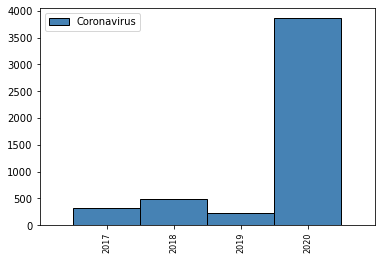

In [66]:
## Kyla Boyd, Working with CORE API
#Code adapted from: https://github.com/oacore/or2016-api-demo/blob/master/OR2016%20API%20demo.ipynb

import urllib.request
import urllib.parse
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

class CoreApiRequestor:

    #Set values for API search
    def __init__(self, endpoint, api_key): 
        self.endpoint = endpoint
        self.api_key = api_key
        #defaults
        self.pagesize = 100
        self.page = 1

    
    def parse_response(self, decoded):
        res = []
        for item in decoded['data']:
            doi = None
            if 'identifiers' in item:
                for identifier in item['identifiers']:
                    if identifier and identifier.startswith('doi:'):
                        doi = identifier
                        break
            res.append([item['title'], doi])
        return res

    #Read search result into html variable
    def request_url(self, url):
        with urllib.request.urlopen(url) as response:
            html = response.read()
        return html

    
    def get_method_query_request_url(self,method,query,fullText,page):
        if (fullText):
            fullText = 'true'
        else:
            fullText = 'false'
        params = {
            'apiKey':self.api_key,
            'page':page,
            'pageSize':self.pagesize,
            'fulltext':fullText
        }
        return self.endpoint + method + '/' + urllib.parse.quote(query) + '?' + urllib.parse.urlencode(params)

    def get_up_to_50_pages_of_query(self,method,query,fulltext):
        url = self.get_method_query_request_url(method,query,fulltext,1)
        all_articles=[]
        resp = self.request_url(url)
        result = json.loads(resp.decode('utf-8'))
        all_articles.append(result)
        if (result['totalHits']>100):
            numOfPages = int(result['totalHits']/self.pagesize)  #rounds down
            if (numOfPages>50):
                numOfPages=50
            for i in range(2,numOfPages):
                url = self.get_method_query_request_url(method,query,False,i)
                #print(url)
                resp =self.request_url(url)
                all_articles.append(json.loads(resp.decode('utf-8')))
        return all_articles

endpoint = 'https://core.ac.uk/api-v2'

api_key = 'GhZNapLecsCSHKiRyfIQF9rxg0zblJk1'

method = '/articles/search'
topic = 'title:*coronavirus* AND year:[2017 TO 2020]'

api = CoreApiRequestor(endpoint,api_key)

url = api.get_method_query_request_url(method,topic,False,1)

result = api.request_url(url)
#result

Result_50page = api.get_up_to_50_pages_of_query(method,topic,False)
#Result_50page[0]

pub_year = []
for page in Result_50page:
    for entry in page['data']:
        if 'year' in entry:
            pub_year.append(entry['year'])
        
#print(pub_year)
cnt = Counter(pub_year)
labels, values = zip(*sorted(cnt.items(), key=lambda x: x[0]))
indices = np.arange(len(labels))
fix, ax = plt.subplots()
ax.bar(indices+1, values, 1, color='steelblue', edgecolor='black', label='Coronavirus')
plt.xlim([0, indices.size+1])
plt.xticks(indices+1.0, labels, fontsize=8, rotation='vertical')
plt.legend()